In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# --------------------------
# 1. Simulate Time Series Data
# --------------------------
n_obs = 1000
start_date = '2020-01-01'
dates = pd.date_range(start=start_date, periods=n_obs, freq='D')
t = np.arange(n_obs)
period = 365

sin_component = np.sin(2 * np.pi * t / period)
cos_component = np.cos(2 * np.pi * t / period)
trend = 0.001 * t
noise = np.random.normal(0, 0.1, n_obs)
value = 5 + sin_component + cos_component + trend + noise

df_sim = pd.DataFrame({
    'date': dates,
    'sin': sin_component,
    'cos': cos_component,
    'trend': trend,
    'noise': noise,
    'value': value
}).set_index('date')

# --------------------------
# 2. Normalize
# --------------------------
norm_df = (df_sim - df_sim.min()) / (df_sim.max() - df_sim.min())
norm_data = norm_df.values

# --------------------------
# 3. Introduce Missingness + value_missing column
# --------------------------
p_miss = 0.2
train_rate = 0.8
No, Dim = norm_data.shape

np.random.seed(1)
mask = np.random.rand(No, Dim) > p_miss
data_m = 1 * mask  # binary mask

data_missing = norm_data.copy()
data_missing[data_m == 0] = 0

# Store missing column in df_sim
value_index = list(df_sim.columns).index("value")
df_sim['value_missing'] = df_sim['value'].copy()
df_sim.loc[data_m[:, value_index] == 0, 'value_missing'] = np.nan

# Split data
idx = np.random.permutation(No)
Train_No = int(train_rate * No)
trainX = data_missing[idx[:Train_No], :]
testX = data_missing[idx[Train_No:], :]
trainM = data_m[idx[:Train_No], :]
testM = data_m[idx[Train_No:], :]

# --------------------------
# 4. Xavier Initialization
# --------------------------
def xavier_init(size):
    in_dim = size[0]
    stddev = 1. / np.sqrt(in_dim / 2.)
    return np.random.normal(0, stddev, size=size)

# --------------------------
# 5. Utility Functions
# --------------------------
def sample_M(m, n, p):
    return 1. * (np.random.uniform(0., 1., size=[m, n]) > p)

def sample_Z(m, n):
    return np.random.uniform(0., 0.01, size=[m, n])

def sample_idx(m, n):
    return np.random.permutation(m)[:n]

# --------------------------
# 6. Hyperparameters
# --------------------------
H_Dim1 = Dim
H_Dim2 = Dim
p_hint = 0.7
alpha = 10
mb_size = 128
epochs = 1000

# --------------------------
# 7. Initialize Networks
# --------------------------
# Discriminator
D_W1 = torch.tensor(xavier_init([Dim * 2, H_Dim1]), requires_grad=True, dtype=torch.float32)
D_b1 = torch.tensor(np.zeros([H_Dim1]), requires_grad=True, dtype=torch.float32)
D_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]), requires_grad=True, dtype=torch.float32)
D_b2 = torch.tensor(np.zeros([H_Dim2]), requires_grad=True, dtype=torch.float32)
D_W3 = torch.tensor(xavier_init([H_Dim2, Dim]), requires_grad=True, dtype=torch.float32)
D_b3 = torch.tensor(np.zeros([Dim]), requires_grad=True, dtype=torch.float32)
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

# Generator
G_W1 = torch.tensor(xavier_init([Dim * 2, H_Dim1]), requires_grad=True, dtype=torch.float32)
G_b1 = torch.tensor(np.zeros([H_Dim1]), requires_grad=True, dtype=torch.float32)
G_W2 = torch.tensor(xavier_init([H_Dim1, H_Dim2]), requires_grad=True, dtype=torch.float32)
G_b2 = torch.tensor(np.zeros([H_Dim2]), requires_grad=True, dtype=torch.float32)
G_W3 = torch.tensor(xavier_init([H_Dim2, Dim]), requires_grad=True, dtype=torch.float32)
G_b3 = torch.tensor(np.zeros([Dim]), requires_grad=True, dtype=torch.float32)
theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

# --------------------------
# 8. Model Functions
# --------------------------
def generator(new_x, m):
    inputs = torch.cat([new_x, m], dim=1)
    h1 = F.relu(torch.matmul(inputs, G_W1) + G_b1)
    h2 = F.relu(torch.matmul(h1, G_W2) + G_b2)
    return torch.sigmoid(torch.matmul(h2, G_W3) + G_b3)

def discriminator(new_x, h):
    inputs = torch.cat([new_x, h], dim=1)
    h1 = F.relu(torch.matmul(inputs, D_W1) + D_b1)
    h2 = F.relu(torch.matmul(h1, D_W2) + D_b2)
    return torch.sigmoid(torch.matmul(h2, D_W3) + D_b3)

# --------------------------
# 9. Loss Functions
# --------------------------
def discriminator_loss(M, New_X, H):
    G_sample = generator(New_X, M)
    Hat_X = M * New_X + (1 - M) * G_sample
    D_prob = discriminator(Hat_X, H)
    return -torch.mean(M * torch.log(D_prob + 1e-8) + (1 - M) * torch.log(1. - D_prob + 1e-8))

def generator_loss(X, M, New_X, H):
    G_sample = generator(New_X, M)
    Hat_X = M * New_X + (1 - M) * G_sample
    D_prob = discriminator(Hat_X, H)
    G_loss1 = -torch.mean((1 - M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample) ** 2) / torch.mean(M)
    G_loss = G_loss1 + alpha * MSE_train_loss
    MSE_test_loss = torch.mean(((1 - M) * X - (1 - M) * G_sample) ** 2) / torch.mean(1 - M)
    return G_loss, MSE_train_loss, MSE_test_loss

# --------------------------
# 10. Optimizers
# --------------------------
optimizer_D = torch.optim.Adam(params=theta_D, lr=0.001)
optimizer_G = torch.optim.Adam(params=theta_G, lr=0.001)

# --------------------------
# 11. Training Loop
# --------------------------
Dloss, Gloss = [], []

for it in tqdm(range(epochs)):
    mb_idx = sample_idx(Train_No, mb_size)
    X_mb = trainX[mb_idx, :]
    M_mb = trainM[mb_idx, :]
    Z_mb = sample_Z(mb_size, Dim)
    H_mb = M_mb * sample_M(mb_size, Dim, 1 - p_hint)
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    X_mb = torch.tensor(X_mb, dtype=torch.float32)
    M_mb = torch.tensor(M_mb, dtype=torch.float32)
    H_mb = torch.tensor(H_mb, dtype=torch.float32)
    New_X_mb = torch.tensor(New_X_mb, dtype=torch.float32)

    optimizer_D.zero_grad()
    D_loss_curr = discriminator_loss(M=M_mb, New_X=New_X_mb, H=H_mb)
    D_loss_curr.backward()
    optimizer_D.step()
    Dloss.append(D_loss_curr.item())

    optimizer_G.zero_grad()
    G_loss_curr, _, MSE_test_loss_curr = generator_loss(X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
    G_loss_curr.backward()
    optimizer_G.step()
    Gloss.append(G_loss_curr.item())

    if it % 100 == 0:
        print(f"Iter {it} | Test RMSE: {np.sqrt(MSE_test_loss_curr.item()):.4f}")



  2%|▏         | 18/1000 [00:00<00:10, 97.59it/s]

Iter 0 | Test RMSE: 0.4044


 12%|█▏        | 120/1000 [00:01<00:08, 99.45it/s]

Iter 100 | Test RMSE: 0.4825


 22%|██▏       | 224/1000 [00:02<00:05, 132.12it/s]

Iter 200 | Test RMSE: 0.4933


 31%|███       | 311/1000 [00:02<00:06, 101.41it/s]

Iter 300 | Test RMSE: 0.4718


 42%|████▏     | 418/1000 [00:03<00:05, 106.61it/s]

Iter 400 | Test RMSE: 0.4449


 51%|█████     | 511/1000 [00:04<00:04, 100.99it/s]

Iter 500 | Test RMSE: 0.4390


 62%|██████▏   | 624/1000 [00:05<00:02, 134.32it/s]

Iter 600 | Test RMSE: 0.4470


 73%|███████▎  | 730/1000 [00:06<00:01, 142.35it/s]

Iter 700 | Test RMSE: 0.4769


 82%|████████▏ | 815/1000 [00:07<00:01, 125.89it/s]

Iter 800 | Test RMSE: 0.4777


 91%|█████████ | 908/1000 [00:08<00:00, 103.79it/s]

Iter 900 | Test RMSE: 0.4620


100%|██████████| 1000/1000 [00:08<00:00, 115.01it/s]


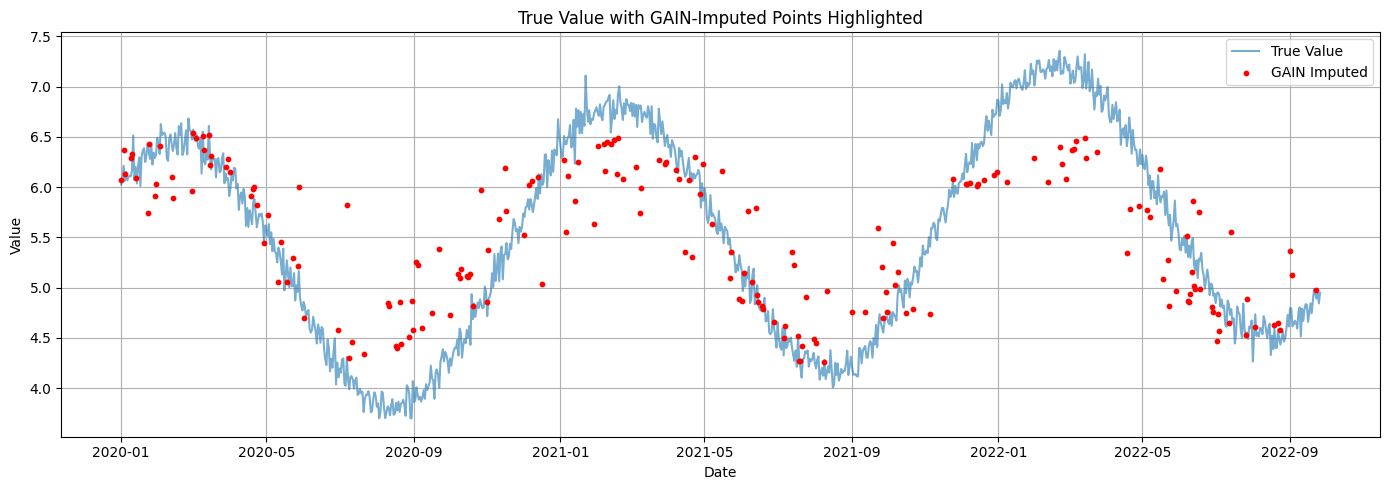

In [ ]:
# --------------------------
# 12. Impute Entire Dataset
# --------------------------
X_full = torch.tensor(data_missing, dtype=torch.float32)
M_full = torch.tensor(data_m, dtype=torch.float32)
Z_full = torch.tensor(sample_Z(No, Dim), dtype=torch.float32)
New_X_full = M_full * X_full + (1 - M_full) * Z_full

G_sample = generator(New_X_full, M_full).detach().numpy()
X_hat = data_m * norm_data + (1 - data_m) * G_sample  # Final imputed matrix

# Denormalize
min_val = df_sim['value'].min()
max_val = df_sim['value'].max()
true_vals = norm_data[:, value_index] * (max_val - min_val) + min_val
imputed_vals = X_hat[:, value_index] * (max_val - min_val) + min_val

# Final result DataFrame
df_sim['final_value'] = df_sim['value_missing'].copy()
df_sim.loc[df_sim['value_missing'].isna(), 'final_value'] = imputed_vals[df_sim['value_missing'].isna()]

# --------------------------
# 13. Plot True vs Imputed
# --------------------------
plt.figure(figsize=(14, 5))
plt.plot(df_sim.index, df_sim['value'], label='True Value', alpha=0.6)
plt.scatter(df_sim[df_sim['value_missing'].isna()].index,
            df_sim[df_sim['value_missing'].isna()]['final_value'],
            color='red', label='GAIN Imputed', s=10, zorder=5)
plt.title("True Value with GAIN-Imputed Points Highlighted")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df_sim[['value', 'value_missing', 'final_value']]


,value,value_missing,final_value
date,,,
2020-01-01,5.953074,NaN,6.036637
2020-01-02,6.052484,6.052484,6.052484
2020-01-03,5.935358,NaN,6.221038
2020-01-04,5.993953,NaN,6.141615
2020-01-05,6.102847,6.102847,6.102847
...,...,...,...
2022-09-22,5.041838,5.041838,5.041838
2022-09-23,4.814728,NaN,4.818953
2022-09-24,5.015133,5.015133,5.015133


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Subset only rows where imputation occurred (originally missing)
missing_only = df_sim[df_sim['value_missing'].isna()]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(missing_only['value'], missing_only['final_value']))
print(f"Imputation RMSE: {rmse:.4f}")


Imputation RMSE: 0.5695
